# Import Libraries

In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

# Loading and Preparing Data

In [26]:
def load_and_prepare_data(excel_path):
    df = pd.read_csv(excel_path)
    # Strip whitespace from Course Code
    df['Course Code'] = df['Course Code'].str.strip()
    df['Original_Year'] = df['Year']
    df['Year'] = pd.to_datetime(df['Year'].astype(str) + '-01-01')
    return df

# Creating Prophet Forecast

In [27]:
def create_prophet_forecast(data, course_code, forecast_years=7):
    """Improved forecasting with more conservative growth predictions"""
    prophet_df = data.rename(columns={'Year': 'ds', 'Enrollment': 'y'})
    
    # Calculate recent trend (last 3 years)
    recent_growth = prophet_df['y'].tail(3).pct_change().mean()
    
    # Calculate overall trend
    overall_growth = prophet_df['y'].pct_change().mean()
    
    # Use a weighted average of recent and overall growth to avoid extreme predictions
    weighted_growth = (recent_growth * 0.7 + overall_growth * 0.3)
    
    # Dampen the growth rate for more conservative predictions
    dampening_factor = 0.5
    weighted_growth = weighted_growth * dampening_factor
    
    # Set course-specific bounds
    historical_max = prophet_df['y'].max()
    historical_min = prophet_df['y'].min()
    current_value = prophet_df['y'].iloc[-1]
    
    if course_code == 'GRAND_TOTAL':
        # More conservative bounds for total enrollment
        cap = min(historical_max * 1.15, current_value * 1.2)
        floor = max(historical_min * 0.95, current_value * 0.8)
    else:
        # Individual course bounds - more conservative
        if weighted_growth > 0:
            cap = min(historical_max * 1.25, current_value * 1.3)
            floor = max(historical_min * 0.9, current_value * 0.75)
        else:
            cap = min(historical_max * 1.1, current_value * 1.15)
            floor = max(historical_min * 0.95, current_value * 0.85)
    
    prophet_df['cap'] = cap
    prophet_df['floor'] = floor
    
    # Define changepoints with more recent data points
    changepoints = pd.date_range(
        start=prophet_df['ds'].min(),
        end=prophet_df['ds'].max(),
        freq='YS'
    )
    
    model = Prophet(
        growth='logistic',
        changepoint_prior_scale=0.0005,  # Reduced for smoother predictions
        seasonality_prior_scale=0.001,
        changepoint_range=0.95,
        interval_width=0.85,  # Wider confidence intervals
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoints=changepoints
    )
    
    model.fit(prophet_df)
    
    # Calculate exact periods needed to reach 2029
    last_year = prophet_df['ds'].dt.year.max()
    periods_needed = 2029 - last_year
    
    future_dates = model.make_future_dataframe(periods=periods_needed, freq='Y')
    future_dates['cap'] = cap
    future_dates['floor'] = floor
    
    forecast = model.predict(future_dates)
    
    # Apply more conservative post-processing
    forecast['yhat'] = forecast['yhat'].clip(lower=floor, upper=cap)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=floor)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(upper=cap)
    
    # Future predictions processing
    future_mask = forecast['ds'].dt.year > last_year
    if not forecast[future_mask].empty:
        # Apply logarithmic growth instead of linear
        years_out = np.array(range(1, len(forecast[future_mask]) + 1))
        growth_factor = np.log1p(years_out * abs(weighted_growth)) * np.sign(weighted_growth)
        base_value = forecast.loc[~future_mask, 'yhat'].iloc[-1]
        
        forecast.loc[future_mask, 'yhat'] = base_value * (1 + growth_factor)
        
        # Ensure predictions stay within bounds
        forecast['yhat'] = forecast['yhat'].clip(lower=floor, upper=cap)
    
    # Smooth the transitions
    forecast['yhat'] = forecast['yhat'].ewm(span=3, adjust=False).mean()
    
    # Convert dates back to years
    forecast['year'] = forecast['ds'].dt.year
    
    return forecast

# Forecasting All Courses

In [28]:
def forecast_all_courses(df):
    forecasts = {}
    
    # First forecast GRAND_TOTAL
    total_data = df[df['Course Code'] == 'GRAND_TOTAL'].copy()
    if not total_data.empty:
        forecasts['GRAND_TOTAL'] = create_prophet_forecast(total_data, 'GRAND_TOTAL')
    
    # Then forecast individual courses
    courses = df[df['Course Code'] != 'GRAND_TOTAL']['Course Code'].unique()
    for course in courses:
        try:
            course_data = df[df['Course Code'] == course].copy()
            if len(course_data) >= 3:
                forecast = create_prophet_forecast(course_data, course)
                forecasts[course] = forecast
        except Exception as e:
            print(f"Error forecasting course {course}: {str(e)}")
    
    return forecasts

# Plotting Forecast

In [29]:
def plot_forecasts(forecasts, actual_data):
    # Set style
    plt.style.available
    
    # First plot GRAND_TOTAL
    if 'GRAND_TOTAL' in forecasts:
        _plot_single_forecast('GRAND_TOTAL', forecasts['GRAND_TOTAL'], actual_data, is_total=True)
    
    # Then plot other courses
    for course in sorted(forecasts.keys()):
        if course != 'GRAND_TOTAL':
            _plot_single_forecast(course, forecasts[course], actual_data, is_total=False)

def _plot_single_forecast(course, forecast, actual_data, is_total=False):
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    actual = actual_data[actual_data['Course Code'] == course]
    plt.plot(actual['Original_Year'], actual['Enrollment'], 
             'ko-', label='Historical', markersize=8, linewidth=2)
    
    # Plot forecast
    future_mask = forecast['year'] > 2022
    
    # Historical fitted values
    plt.plot(forecast[~future_mask]['year'], forecast[~future_mask]['yhat'],
             'b--', label='Fitted', alpha=0.6, linewidth=2)
    
    # Future predictions
    plt.plot(forecast[future_mask]['year'], forecast[future_mask]['yhat'],
             'b-', label='Forecast', linewidth=2)
    
    # Confidence intervals for future predictions only
    plt.fill_between(
        forecast[future_mask]['year'],
        forecast[future_mask]['yhat_lower'],
        forecast[future_mask]['yhat_upper'],
        color='blue', alpha=0.1,
        label='80% Confidence Interval'
    )
    
    # Annotate future points
    for year, value in zip(forecast[future_mask]['year'], forecast[future_mask]['yhat']):
        plt.annotate(
            f'{int(round(value))}',
            (year, value),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.7)
        )
    
    title = 'Total Enrollment Forecast' if is_total else f'Enrollment Forecast for {course}'
    plt.title(title, pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Enrollment', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Improve x-axis
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    plt.xticks(rotation=45)
    
    # Set y-axis to start from 0
    ymax = max(actual['Enrollment'].max() * 1.2, forecast[future_mask]['yhat_upper'].max() * 1.1)
    plt.ylim(bottom=0, top=ymax)
    
    plt.tight_layout()
    plt.show()

# Forecast Summary

In [30]:
def create_forecast_summary(forecasts):
    summary = {}
    
    for course, forecast in forecasts.items():
        # Get the future predictions (excluding historical dates)
        current_year = datetime.now().year
        future_forecast = forecast[forecast['year'] > current_year]
        
        summary[course] = {
            'Years': future_forecast['year'].values,
            'Predicted_Values': future_forecast['yhat'].values,
            'Lower_Bound': future_forecast['yhat_lower'].values,
            'Upper_Bound': future_forecast['yhat_upper'].values
        }
    
    return summary

# Model Evaluation

In [ ]:
def calculate_metrics(actual, predicted):
    """
    Calculate various error metrics for model evaluation.
    
    Parameters:
    actual: array-like - Actual values
    predicted: array-like - Predicted values
    
    Returns:
    dict: Dictionary containing various error metrics
    """
    errors = actual - predicted
    percentage_errors = errors / actual * 100
    abs_errors = np.abs(errors)
    abs_percentage_errors = np.abs(percentage_errors)
    
    metrics = {
        'MAE': np.mean(abs_errors),  # Mean Absolute Error
        'MAPE': np.mean(abs_percentage_errors),  # Mean Absolute Percentage Error
        'MPE': np.mean(percentage_errors),  # Mean Percentage Error
        'R2': 1 - (np.sum(errors ** 2) / np.sum((actual - np.mean(actual)) ** 2))  # R-squared
    }
    
    return metrics

def cross_validate_prophet(data, course_code, initial_period=3, step=1):
    """
    Perform rolling cross-validation for Prophet model.
    
    Parameters:
    data: DataFrame - Training data
    course_code: str - Course code for setting appropriate bounds
    initial_period: int - Minimum number of years required for training
    step: int - Number of years to step forward in each iteration
    
    Returns:
    dict: Dictionary containing cross-validation results
    """
    cv_results = []
    
    # Sort data by date
    data = data.sort_values('ds')
    
    # Calculate the number of possible iterations
    n_iterations = len(data) - initial_period
    
    for i in range(0, n_iterations, step):
        # Split data into training and validation sets
        train = data.iloc[:initial_period + i]
        val = data.iloc[initial_period + i:initial_period + i + step]
        
        if len(val) == 0:
            continue
            
        # Create and fit model
        forecast = create_prophet_forecast(train, course_code)
        
        # Get predictions for validation period
        val_predictions = forecast[forecast['ds'].isin(val['ds'])]
        
        # Calculate metrics
        metrics = calculate_metrics(val['y'].values, val_predictions['yhat'].values)
        metrics['cutoff'] = train['ds'].iloc[-1]
        metrics['val_period'] = val['ds'].iloc[0]
        
        cv_results.append(metrics)
    
    return cv_results

def evaluate_forecast_accuracy(forecasts, actual_data):
    """
    Evaluate forecast accuracy for all courses with proper interval metrics.
    
    Parameters:
    forecasts: dict - Dictionary of forecasts for each course
    actual_data: DataFrame - Original data with actual values
    
    Returns:
    dict: Dictionary containing evaluation results for each course
    """
    evaluation_results = {}
    
    for course, forecast in forecasts.items():
        try:
            # Get actual data for the course
            course_data = actual_data[actual_data['Course Code'] == course].copy()
            course_data = course_data.rename(columns={'Year': 'ds', 'Enrollment': 'y'})
            
            # Calculate in-sample metrics
            historical_mask = forecast['ds'].isin(course_data['ds'])
            historical_predictions = forecast[historical_mask]
            
            if len(historical_predictions) > 0:
                # Merge actual and predicted values
                evaluation_df = pd.merge(
                    course_data,
                    historical_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
                    on='ds',
                    how='inner'
                )
                
                # Calculate basic metrics
                metrics = calculate_metrics(evaluation_df['y'].values, evaluation_df['yhat'].values)
                
                # Perform cross-validation
                cv_results = cross_validate_prophet(course_data, course)
                
                # Calculate interval metrics
                in_interval_mask = ((evaluation_df['y'] >= evaluation_df['yhat_lower']) & 
                                  (evaluation_df['y'] <= evaluation_df['yhat_upper']))
                below_interval_mask = (evaluation_df['y'] < evaluation_df['yhat_lower'])
                above_interval_mask = (evaluation_df['y'] > evaluation_df['yhat_upper'])
                
                interval_metrics = {
                    'interval_coverage': in_interval_mask.mean() * 100,
                    'below_interval': below_interval_mask.mean() * 100,
                    'above_interval': above_interval_mask.mean() * 100,
                    'interval_data': evaluation_df
                }
                
                evaluation_results[course] = {
                    'in_sample_metrics': metrics,
                    'cross_validation': cv_results,
                    **interval_metrics  # Unpack interval metrics into the main dictionary
                }
        except Exception as e:
            print(f"Error evaluating course {course}: {str(e)}")
            # Initialize with default values if evaluation fails
            evaluation_results[course] = {
                'in_sample_metrics': {
                    'MAE': 0.0,
                    'MAPE': 0.0,
                    'MPE': 0.0,
                    'R2': 0.0
                },
                'cross_validation': [],
                'interval_coverage': 0.0,
                'below_interval': 0.0,
                'above_interval': 0.0,
                'interval_data': pd.DataFrame()
            }
    
    return evaluation_results

def plot_evaluation_results(evaluation_results):
    """
    Plot evaluation metrics for all courses.
    """
    courses = list(evaluation_results.keys())
    metrics = ['MAE', 'MAPE']
    
    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))
    fig.suptitle('Forecast Evaluation Metrics by Course', fontsize=16, y=1.02)
    
    for i, metric in enumerate(metrics):
        values = [evaluation_results[course]['in_sample_metrics'][metric] 
                 for course in courses]
        
        sns.barplot(x=values, y=courses, ax=axes[i])
        axes[i].set_title(f'{metric} by Course')
        axes[i].set_xlabel(metric)
        axes[i].set_ylabel('Course')
    
    plt.tight_layout()
    plt.show()

def plot_prediction_interval_coverage(evaluation_results):
    """
    Visualize prediction interval coverage and reliability across courses.
    
    Parameters:
    evaluation_results: dict - Dictionary containing evaluation results for each course
    """
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    courses = list(evaluation_results.keys())
    coverage_data = []
    below_data = []
    above_data = []
    
    for course in courses:
        coverage_data.append(evaluation_results[course]['interval_coverage'])
        below_data.append(evaluation_results[course]['below_interval'])
        above_data.append(evaluation_results[course]['above_interval'])
    
    # Create positions for bars
    x = np.arange(len(courses))
    width = 0.25
    
    # Plot stacked bars
    plt.bar(x, coverage_data, width, label='Within Interval', color='#2ecc71')
    plt.bar(x, below_data, width, bottom=coverage_data, label='Below Interval', color='#e74c3c')
    plt.bar(x, above_data, width, bottom=np.array(coverage_data) + np.array(below_data),
            label='Above Interval', color='#f1c40f')
    
    # Customize plot
    plt.title('Prediction Interval Coverage Analysis by Course', pad=20)
    plt.xlabel('Course')
    plt.ylabel('Percentage')
    plt.xticks(x, courses, rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add target line
    plt.axhline(y=85, color='black', linestyle='--', alpha=0.5, label='Target Coverage (85%)')
    
    # Add percentage labels
    for i, course in enumerate(courses):
        plt.text(i, 50, f"{coverage_data[i]:.1f}%", ha='center', va='center')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # Create second plot for time series
    plt.figure(figsize=(15, 8))
    
    for course in courses:
        data = evaluation_results[course]['interval_data']
        if not data.empty:
            data = data.sort_values('ds')
            
            plt.fill_between(data['ds'], 
                            data['yhat_lower'],
                            data['yhat_upper'],
                            alpha=0.2,
                            label=f'{course} Interval')
            plt.plot(data['ds'], data['y'], 'o',
                    label=f'{course} Actual',
                    markersize=4)
    
    plt.title('Prediction Intervals and Actual Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Enrollment')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Main Function

13:34:32 - cmdstanpy - INFO - Chain [1] start processing
13:34:40 - cmdstanpy - INFO - Chain [1] done processing
13:34:40 - cmdstanpy - INFO - Chain [1] start processing
13:34:42 - cmdstanpy - INFO - Chain [1] done processing
13:34:42 - cmdstanpy - INFO - Chain [1] start processing
13:34:42 - cmdstanpy - INFO - Chain [1] done processing
13:34:43 - cmdstanpy - INFO - Chain [1] start processing
13:34:43 - cmdstanpy - INFO - Chain [1] done processing
13:34:43 - cmdstanpy - INFO - Chain [1] start processing
13:34:44 - cmdstanpy - INFO - Chain [1] done processing
13:34:45 - cmdstanpy - INFO - Chain [1] start processing
13:34:45 - cmdstanpy - INFO - Chain [1] done processing
13:34:45 - cmdstanpy - INFO - Chain [1] start processing
13:34:47 - cmdstanpy - INFO - Chain [1] done processing
13:34:47 - cmdstanpy - INFO - Chain [1] start processing
13:34:52 - cmdstanpy - INFO - Chain [1] done processing
13:34:52 - cmdstanpy - INFO - Chain [1] start processing
13:35:01 - cmdstanpy - INFO - Chain [1]


Forecast Evaluation Summary:

GRAND_TOTAL:
In-sample metrics:
  MAE: 847.43
  RMSE: 972.74
  MAPE: 32.40
  MPE: -21.16
  R2: -0.15
Prediction Interval Coverage: 44.4%

BEED:
In-sample metrics:
  MAE: 90.09
  RMSE: 110.55
  MAPE: 47.55
  MPE: -8.80
  R2: -0.09
Prediction Interval Coverage: 33.3%

BSA:
In-sample metrics:
  MAE: 127.68
  RMSE: 141.31
  MAPE: 56.21
  MPE: -31.57
  R2: -0.00
Prediction Interval Coverage: 33.3%

BSBA:
In-sample metrics:
  MAE: 185.08
  RMSE: 221.34
  MAPE: 35.14
  MPE: -11.79
  R2: -0.01
Prediction Interval Coverage: 44.4%

BSCS:
In-sample metrics:
  MAE: 76.78
  RMSE: 101.17
  MAPE: 37.29
  MPE: 27.44
  R2: -0.78
Prediction Interval Coverage: 55.6%

BSECE:
In-sample metrics:
  MAE: 152.36
  RMSE: 267.33
  MAPE: 38.52
  MPE: 9.21
  R2: -0.24
Prediction Interval Coverage: 33.3%

BSED-ENG:
In-sample metrics:
  MAE: 36.74
  RMSE: 43.94
  MAPE: 33.84
  MPE: -23.12
  R2: -0.12
Prediction Interval Coverage: 44.4%

BSED-FIL:
In-sample metrics:
  MAE: 63.45
  RMSE:

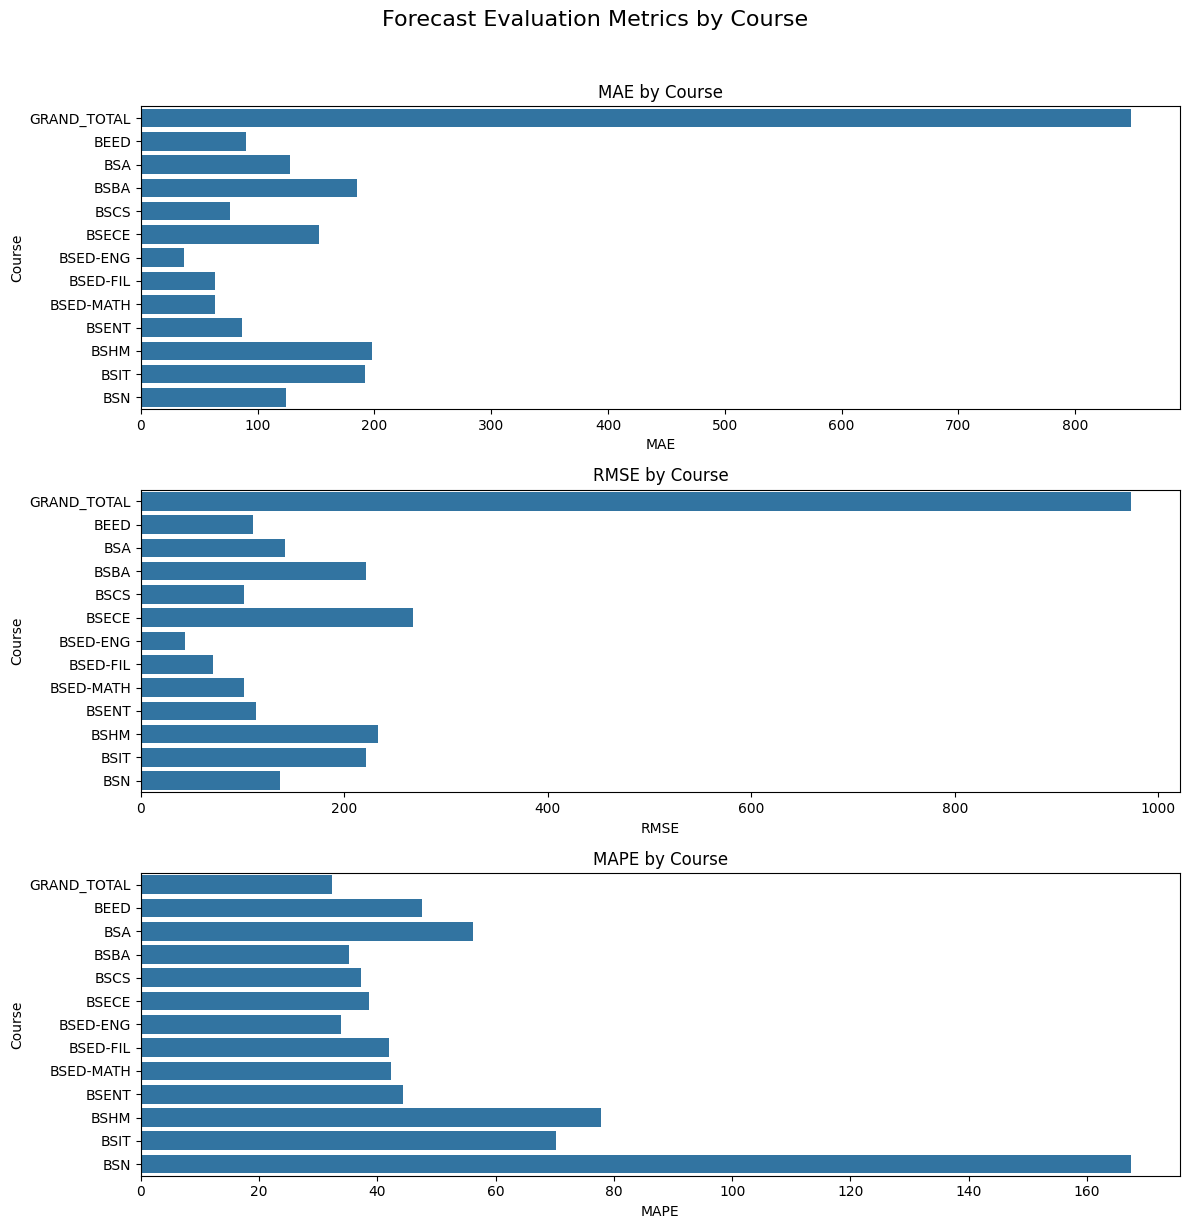

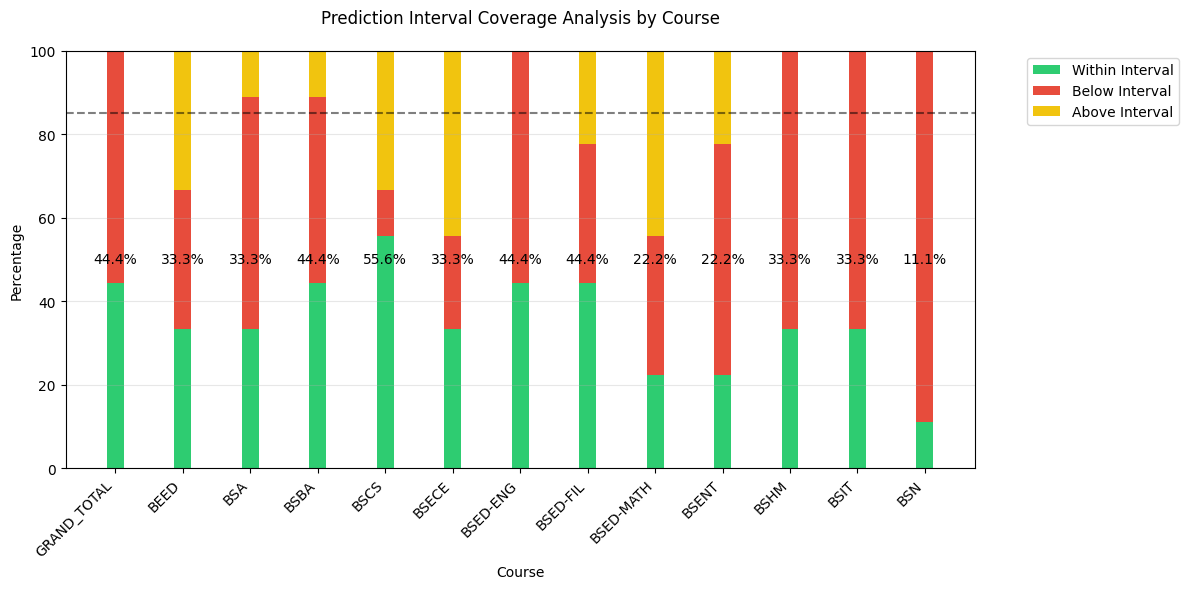

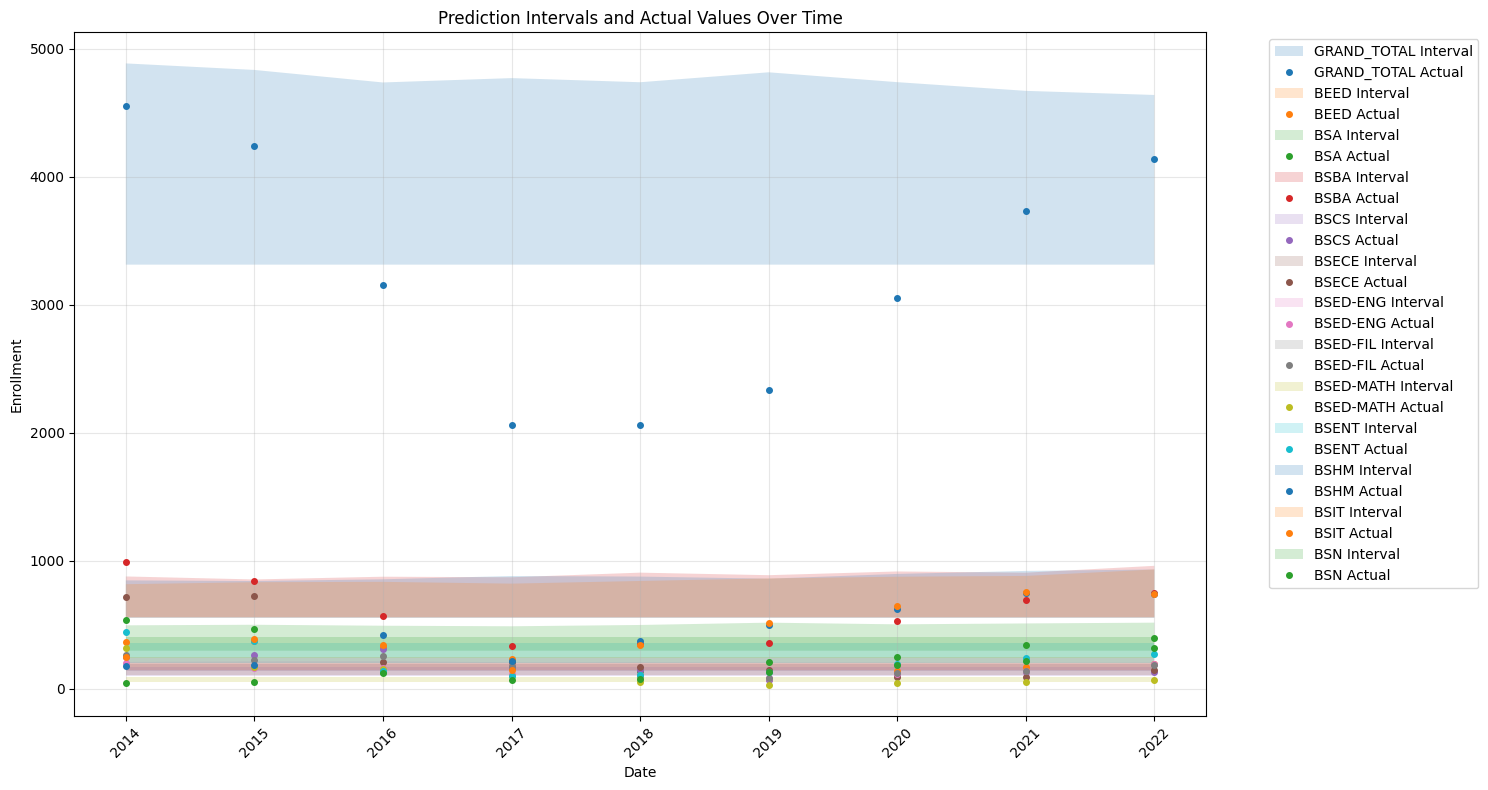


Forecast Summary for GRAND_TOTAL:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 3902.80        | 3312.80     | 4542.60
  2026  | 4070.09        | 3312.80     | 4629.74
  2027  | 4236.08        | 3312.80     | 4463.19
  2028  | 4397.70        | 3312.80     | 4522.96

Forecast Summary for BEED:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 195.72        | 144.00     | 249.60
  2026  | 204.47        | 144.00     | 249.60
  2027  | 213.14        | 144.00     | 249.60
  2028  | 221.56        | 144.00     | 249.60

Forecast Summary for BSA:
  Year   | Predicted Value | Lower Bound | Upper Bound
  ---------------------------------------------
  2025  | 389.51        | 298.50     | 517.40
  2026  | 414.90        | 298.50     | 517.40
  2027  | 439.23        | 298.50     | 517.40
  2028  | 462.25        | 298.50     | 517.40

Forecast Summary for BSBA:
  Year   

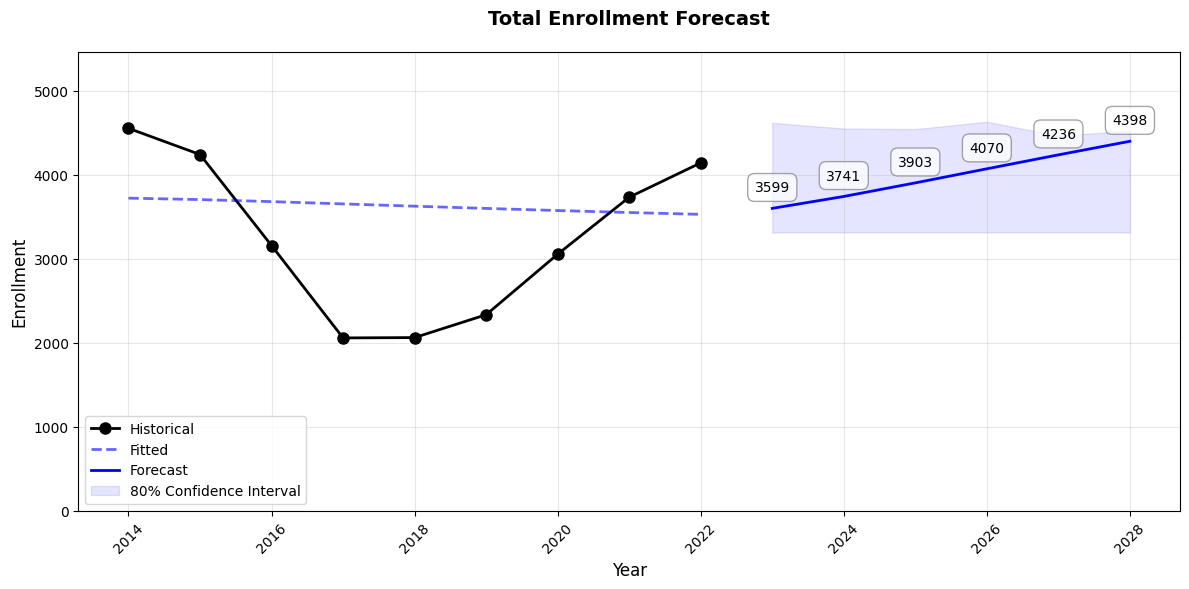

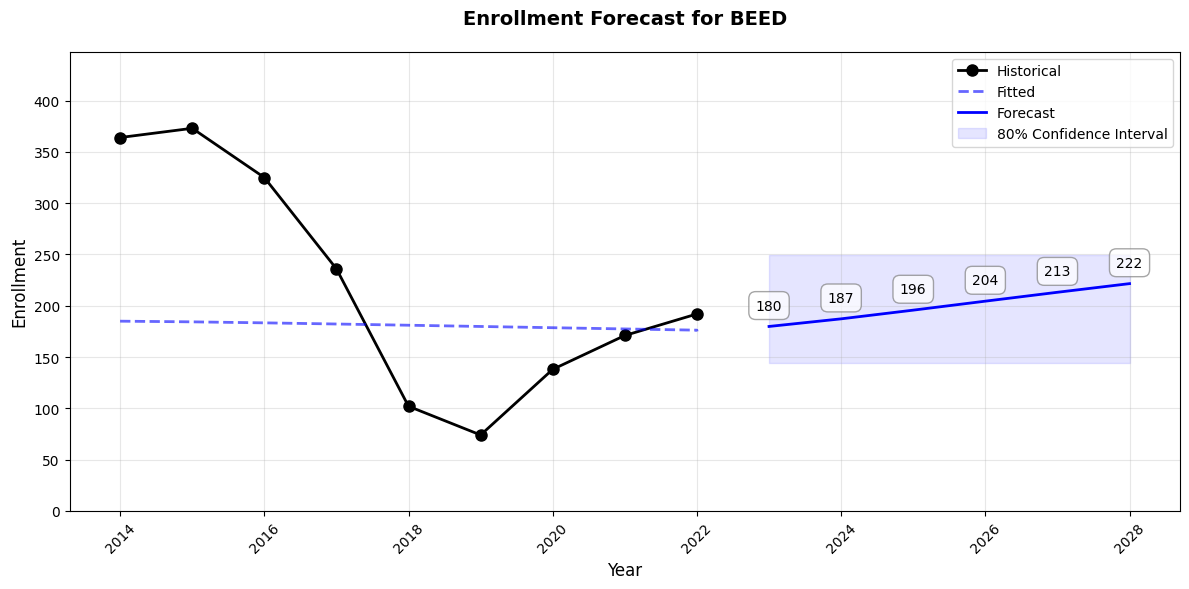

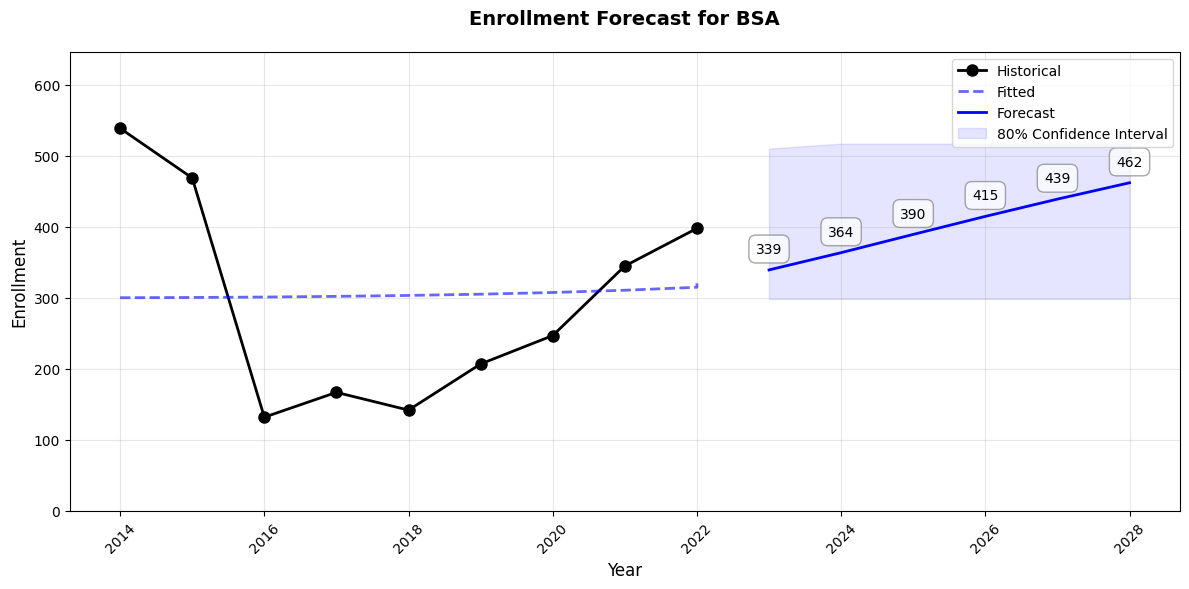

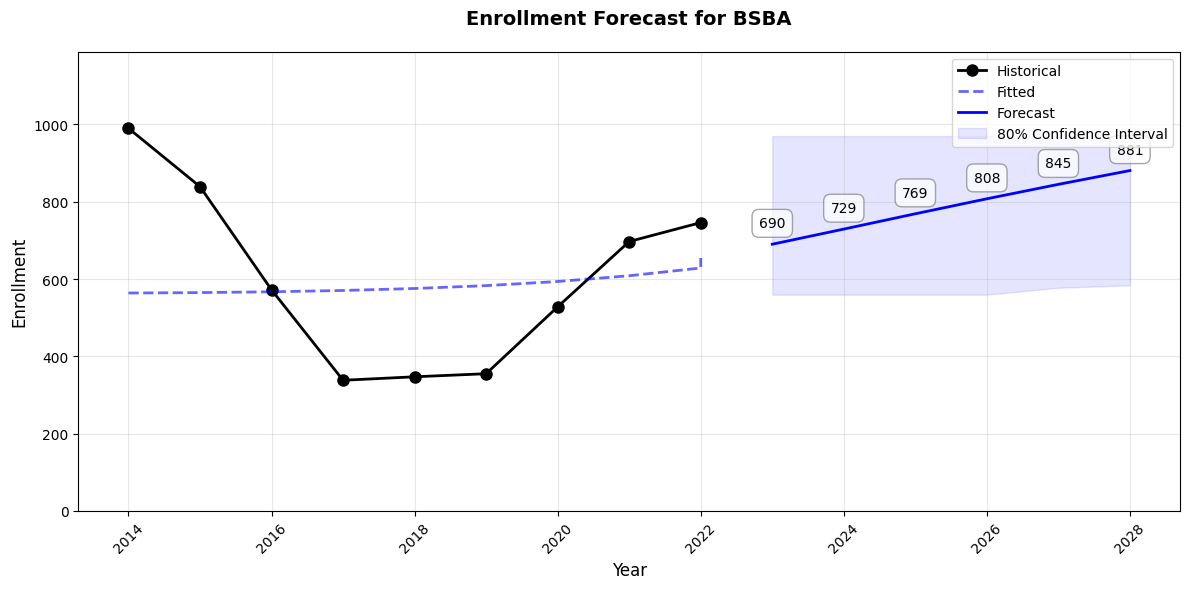

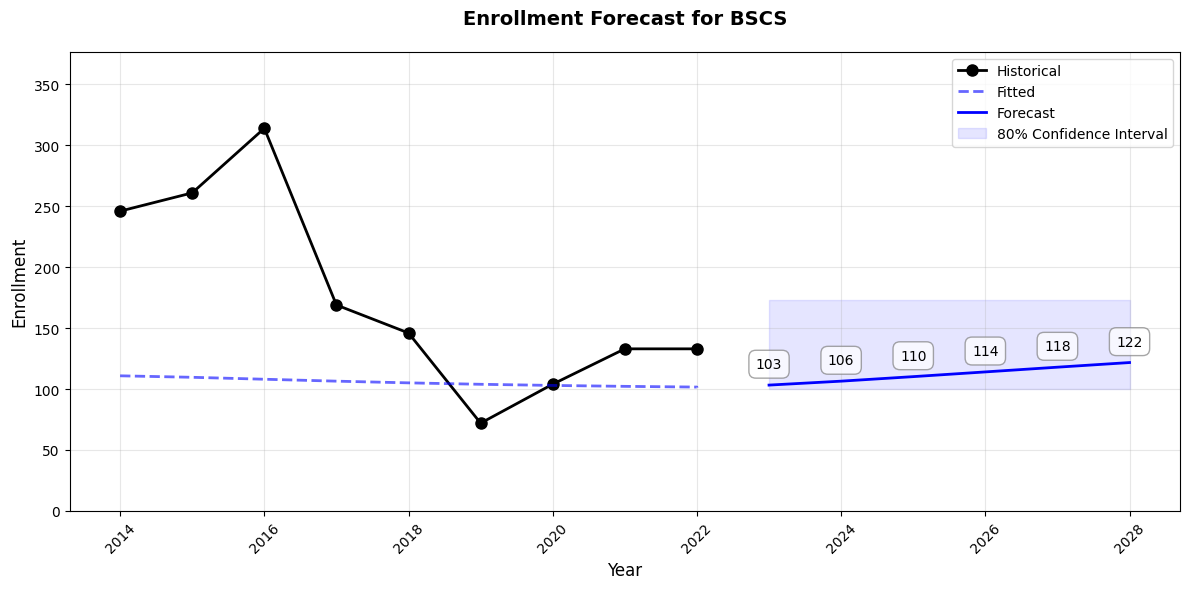

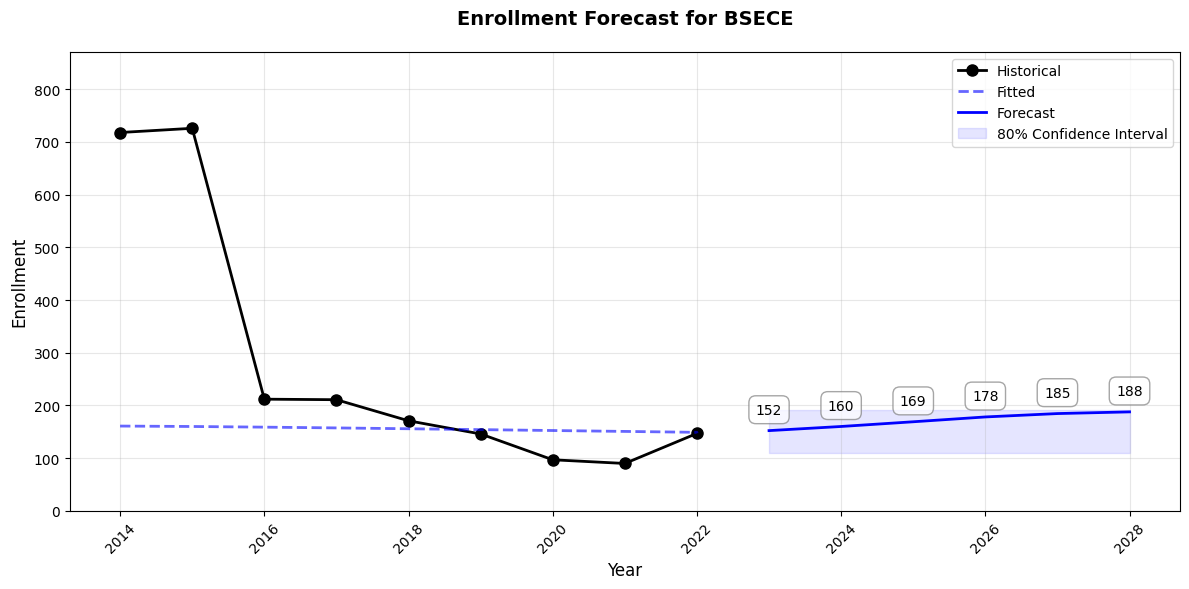

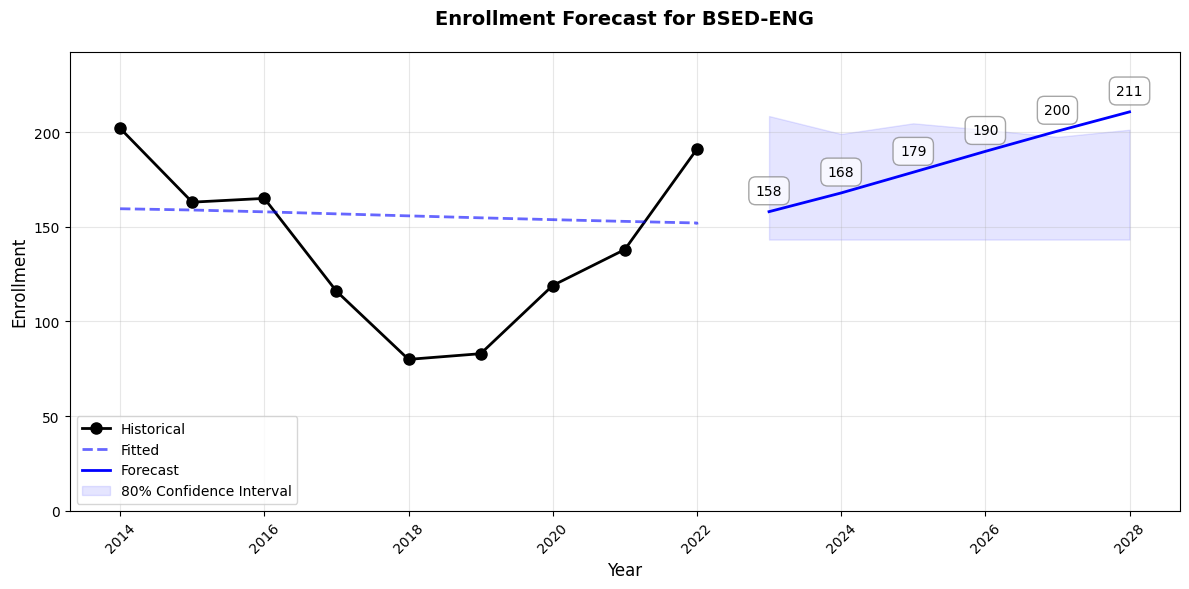

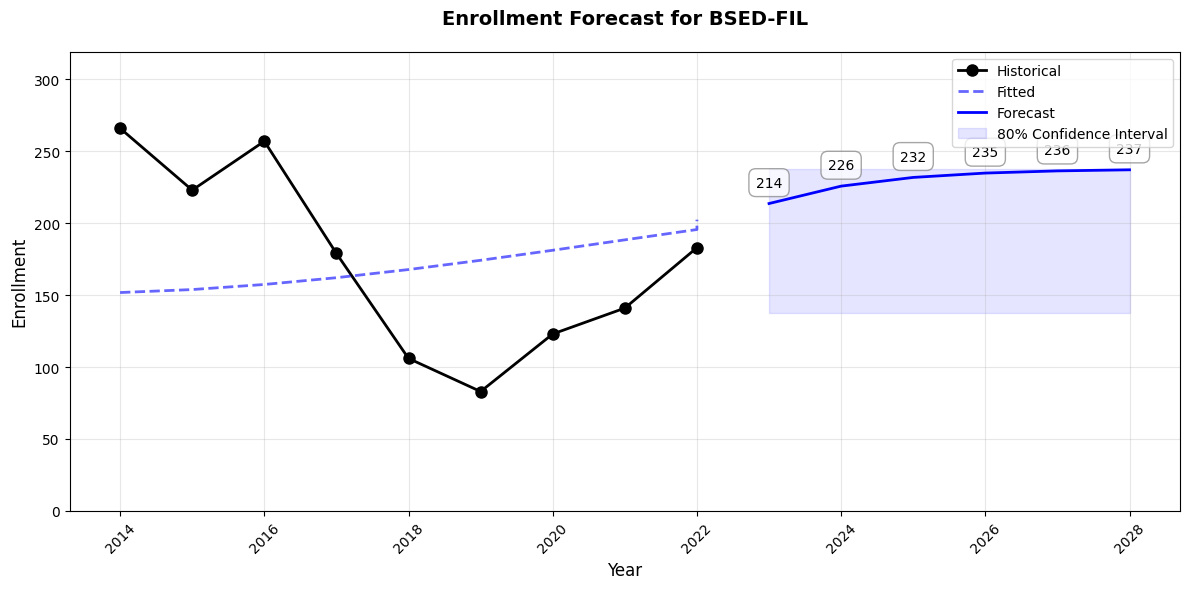

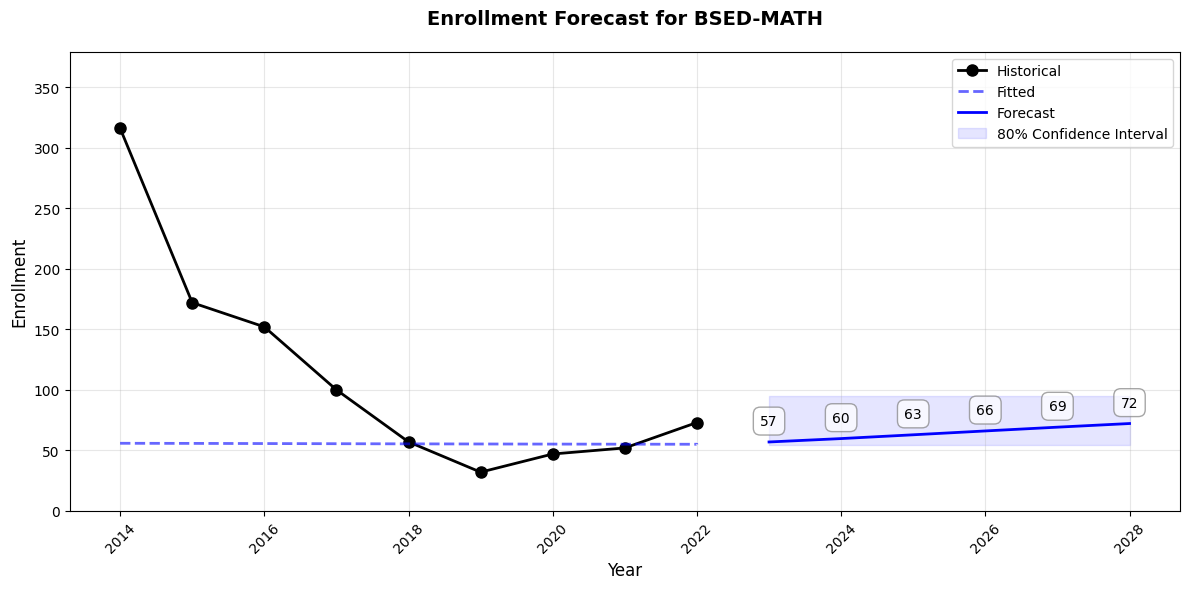

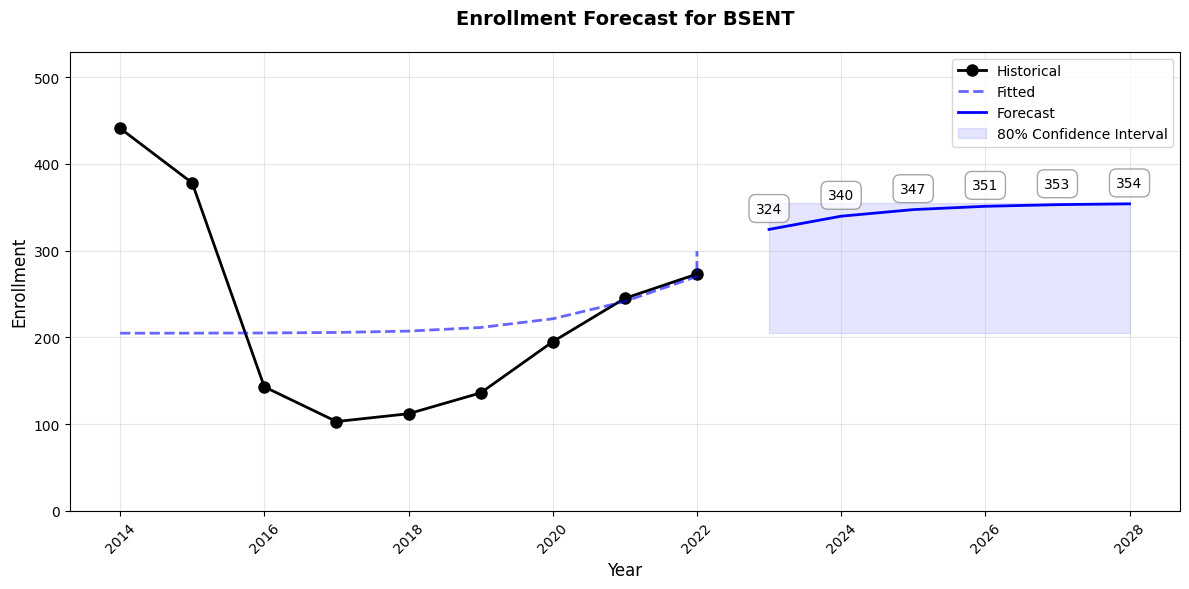

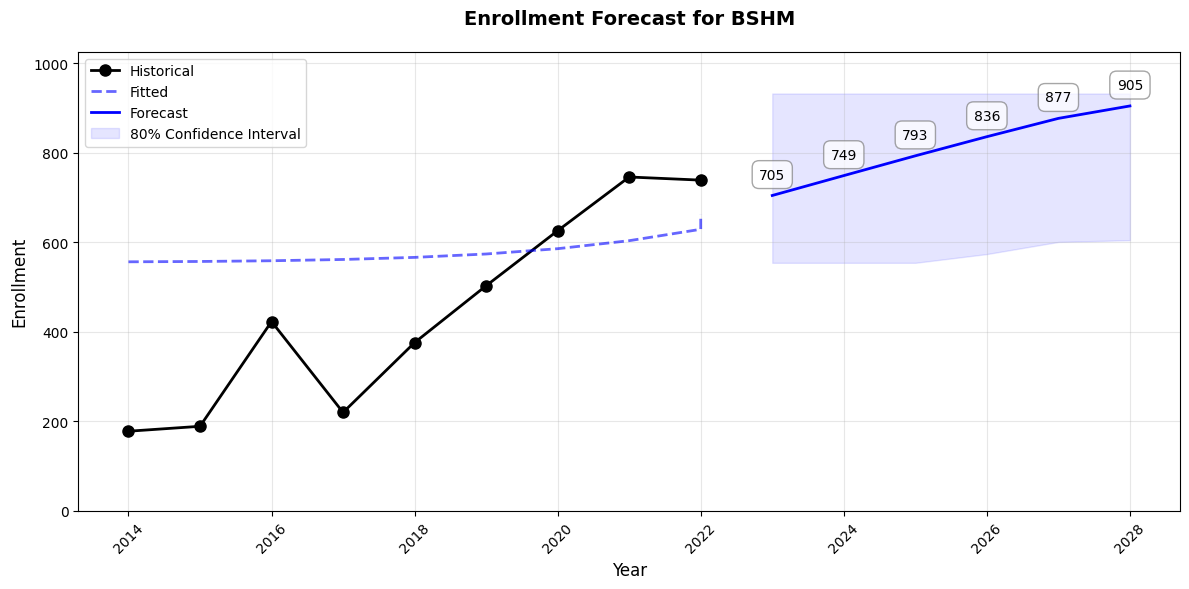

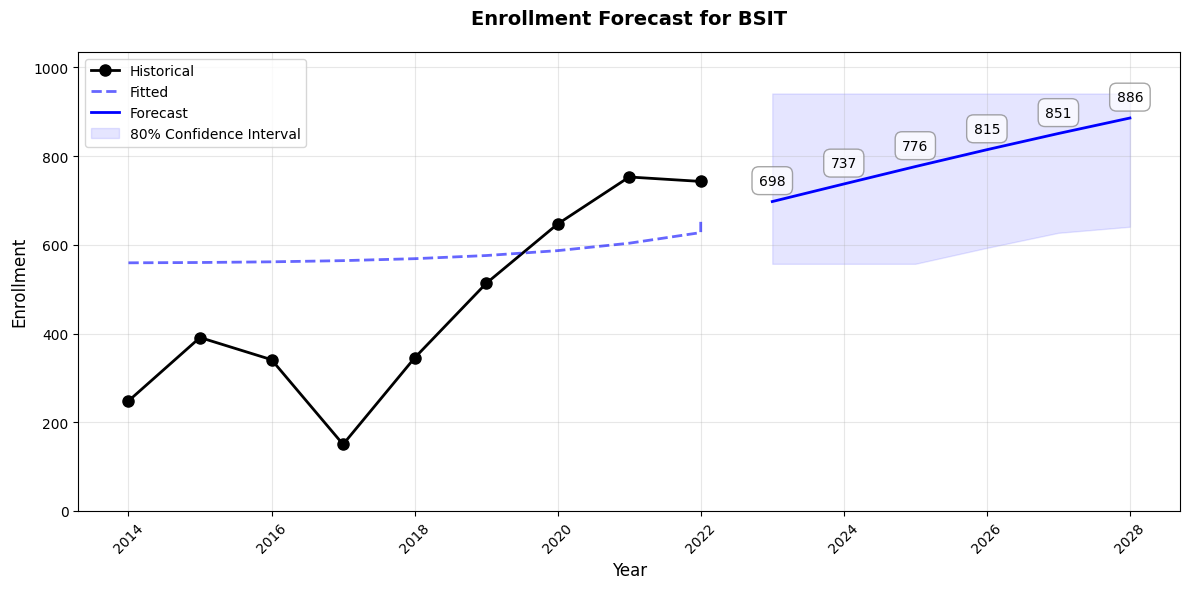

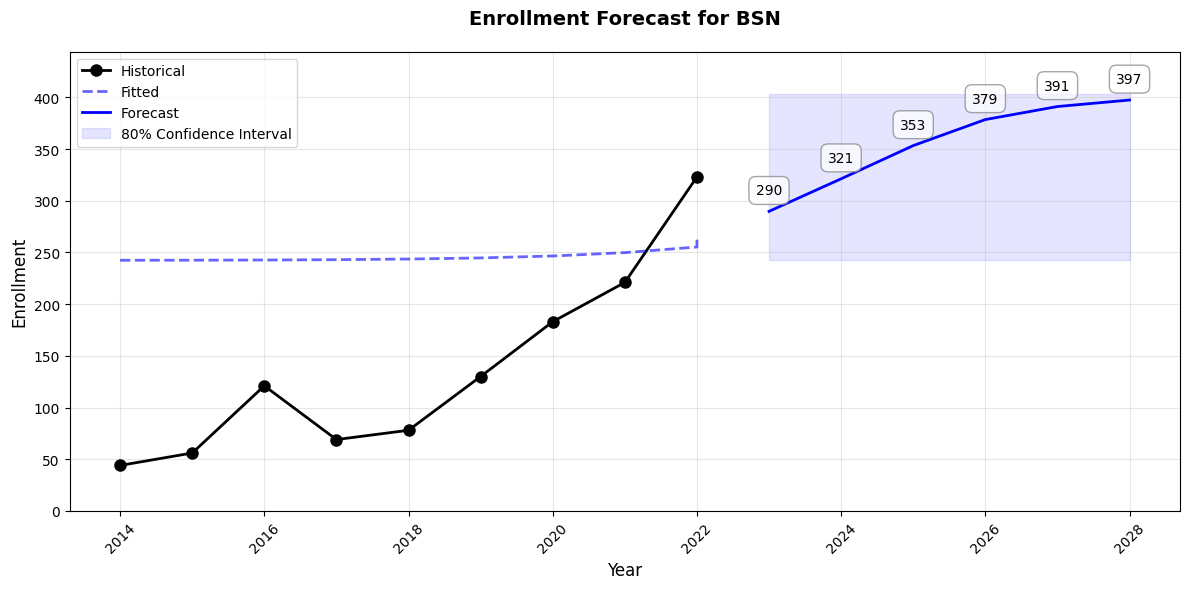

In [32]:
def main():
    excel_path = r'C:\Users\acer\Desktop\plp-enrollment-insights-dashboardd\src\lib\ml\data\EnrollmentData.csv'
    df = load_and_prepare_data(excel_path)
    forecasts = forecast_all_courses(df)

    # Evaluate forecasts
    evaluation_results = evaluate_forecast_accuracy(forecasts, df)
    
    # Print evaluation summary
    print("\nForecast Evaluation Summary:")
    print("=" * 50)
    for course, results in evaluation_results.items():
        print(f"\n{course}:")
        print("In-sample metrics:")
        for metric, value in results['in_sample_metrics'].items():
            print(f"  {metric}: {value:.2f}")
        print(f"Prediction Interval Coverage: {results['interval_coverage']:.1f}%")
    
    # Plot all evaluation visualizations
    plot_evaluation_results(evaluation_results)
    plot_prediction_interval_coverage(evaluation_results)
    

    # Create and print a more readable summary
    summary = create_forecast_summary(forecasts)
    for course, details in summary.items():
        print(f"\nForecast Summary for {course}:")
        print("  Year   | Predicted Value | Lower Bound | Upper Bound")
        print("  " + "-" * 45)
        for year, predicted, lower, upper in zip(details['Years'], details['Predicted_Values'], details['Lower_Bound'], details['Upper_Bound']):
            print(f"  {year}  | {predicted:.2f}        | {lower:.2f}     | {upper:.2f}")

    plot_forecasts(forecasts, df)

if __name__ == "__main__":
    main()